In [1]:
import xarray as xr # Import the Xarray package
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Import the Numpy package
import cartopy,cartopy.crs as ccrs # Plot maps
import cartopy.feature as cfeature # Collection of points, lines and polygons
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER # Add gridlines and tick labels to a map
import cartopy.io.shapereader as shpreader # Oriented shapefile reader
from netCDF4 import Dataset # Read/Write NetCDF4 files
from datetime import datetime, timedelta # Basics Dates and time types
from matplotlib import cm # Colormap handling utilities
import metpy
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
from mpl_toolkits.basemap import Basemap
#from utilities import loadCPT
from scipy.ndimage.filters import maximum_filter, minimum_filter
import scipy.ndimage as ndimage
from ecmwf.opendata import Client

In [2]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        txt1 = ax.annotate(symbol, xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]), 
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), color=color, size=20,
                clip_on=True, annotation_clip=True, horizontalalignment='center', verticalalignment='center',
                transform=ccrs.PlateCarree())

        txt2 = ax.annotate('\n' + str(int(data[mxy[i], mxx[i]])), xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]),
                           xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), 
                color=color, size=20, clip_on=True, annotation_clip=True, fontweight='bold', 
                           horizontalalignment='center', verticalalignment='top',
                transform=ccrs.PlateCarree())  


Os arquivos podem ser baixados no site: https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi

In [3]:
ds13=xr.open_dataset('C:/Users/igorr/Downloads/OR_ABI-L2-CMIPF-M6C13_G16_s20233191240206_e20233191249526_c20233191249590.nc')
ds13

<xarray.Dataset>
Dimensions:                                           (y: 5424, x: 5424, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1518 ... ...
  * x                                                 (x) float32 -0.1518 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_wavelength                                   (band) float32 ...
    band_id                                           (band) int32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band
Data variables: (12/35)
    CMI                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-11-15T12:40:20.6Z
    time_coverage_end:         2023-11-15T12:49:52.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        657bd807-a37c-43c7-98a0-01cf2b89b432

In [4]:
dat13 = ds13.metpy.parse_cf('CMI')
dat13=dat13-273.15
geos = dat13.metpy.cartopy_crs

x = dat13.x
y = dat13.y

In [5]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(ds13.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
date=scan_start
# Scan's end time, converted to datetime object
scan_end = datetime.strptime(ds13.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(ds13.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(ds13['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2023-11-15 12:40:20.600000
Scan midpoint : 2023-11-15 12:45:06.600000
Scan End      : 2023-11-15 12:49:52.600000
File Created  : 2023-11-15 12:49:59
Scan Duration : 9.53 minutes


In [6]:
vmin=None
vmax=None

In [9]:
from ecmwf.opendata import Client
#client = Client("ecmwf", beta=True)
client = Client()
client.retrieve(
    date=20231115, # data da inicialização do modelo
    time=0,       # hora da rodada do modelo
    step=12,      # hora analisada
    stream="oper",
    type="fc",
    levtype="sfc",
    param="msl",
    target="data.grib2"
)

20231115000000-12h-oper-fc.grib2:   0%|          | 0.00/227k [00:00<?, ?B/s]

In [10]:
ds=xr.open_dataset("data.grib2", engine="cfgrib")
ds

Ignoring index file 'data.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    meanSea     float64 ...
  * latitude    (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  datetime64[ns] ...
Data variables:
    msl         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-11-15T09:58 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
pa=ds['msl']/100
lon=ds['longitude']
lat=ds['latitude']

In [12]:
paP=ndimage.gaussian_filter(pa,sigma=0.7,order=0)

AMÉRICA DO SUL

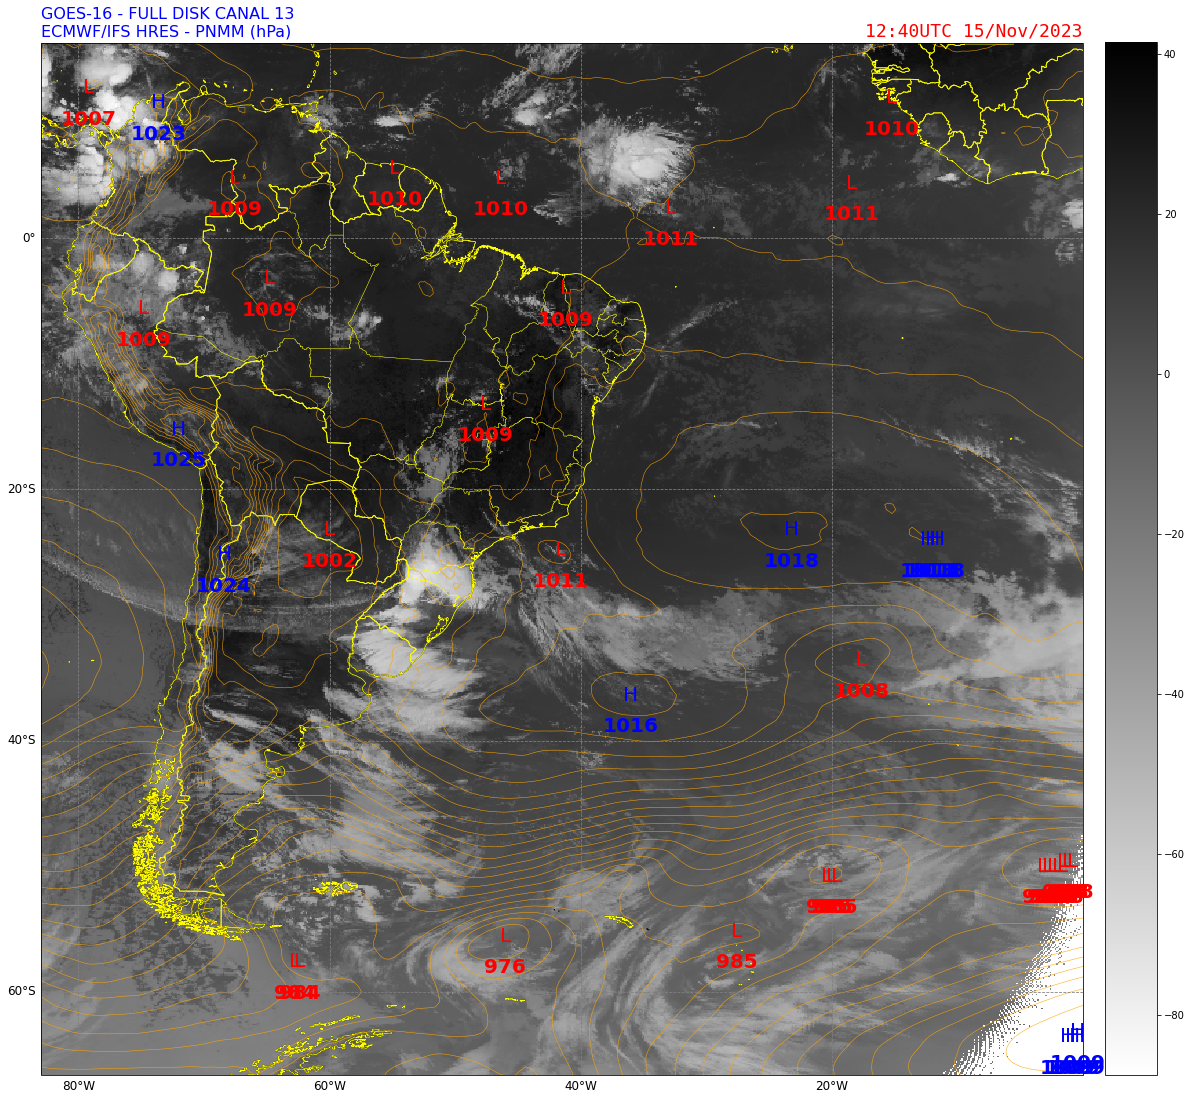

In [13]:
lon,lat=np.meshgrid(pa.longitude,pa.latitude)
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m")
#ax.set_extent([-83,-10,12,-60])
ax.set_extent([-83,0,12,-60])
#ax.set_extent([-58, -48, -22, -34])
im=ax.imshow(dat13,cmap='gray_r',
              #cmap=my_cmap,
             
              vmin=vmin,vmax=vmax,
              origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')

im1=ax.contour(lon,lat,paP,np.arange(922,1082,2),
               linewidths=.5,
               colors='orange',
               transform=ccrs.PlateCarree())

plot_maxmin_points(lon,lat,pa,'max',40,symbol='H',
                   color='blue',
                   transform=ccrs.PlateCarree())
plot_maxmin_points(lon,lat,pa,'min',20,symbol='L',
                   color='red',
                   transform=ccrs.PlateCarree())

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='yellow',facecolor='none',linestyle='-',linewidth=0.8)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='yellow',facecolor='none',linestyle='-',linewidth=0.3)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}

#ax.clabel(im1, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'orange')
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.0463,orientation='vertical')
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
plt.title('GOES-16 - FULL DISK CANAL 13\nECMWF/IFS HRES - PNMM (hPa)',
          fontsize=16,loc='left',color='blue')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC')),fontsize=18,loc='right',
#          color='blue',fontweight='normal',fontfamily='monospace')
plt.title('{}'.format(scan_start.strftime('%H:%MUTC %d/%b/%Y')),fontsize=18,loc='right',
          color='red',fontweight='normal',fontfamily='monospace')
plt.savefig('GOES16_CH13_AS_'+scan_start.strftime('%H_%MUTC_%d_%b_%Y')+'.jpeg',dpi=300,bbox_inches='tight')

OUTRAS REGIÕES

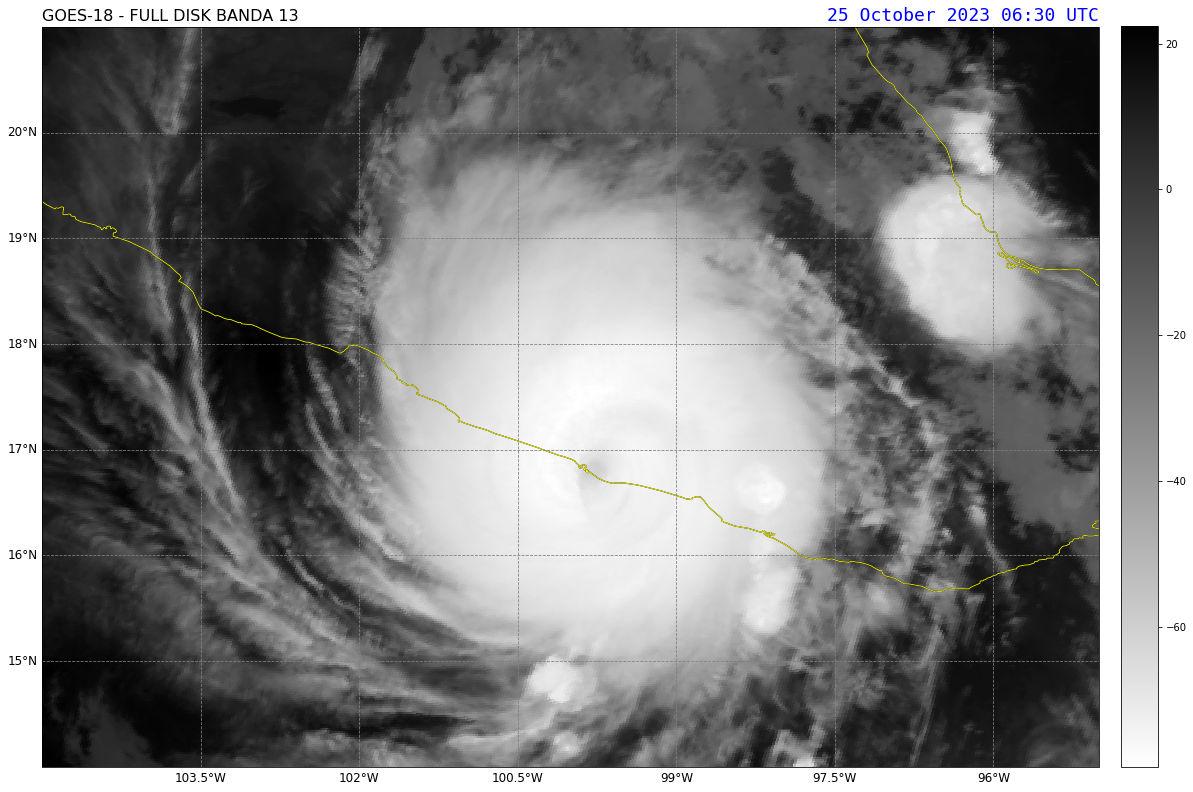

In [15]:
lon,lat=np.meshgrid(pa.longitude,pa.latitude)
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m")
ax.set_extent([-105,-95,21,14])
im=ax.imshow(dat13,cmap='gray_r',
              #cmap=my_cmap,
             
              vmin=vmin,vmax=vmax,
              origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')

#im1=ax.contour(lon,lat,paP,np.arange(922,1082,2),
#               linewidths=.5,
#               colors='orange',
#               transform=ccrs.PlateCarree())

#plot_maxmin_points(lon,lat,pa,'max',40,symbol='H',
#                   color='blue',
#                   transform=ccrs.PlateCarree())
#plot_maxmin_points(lon,lat,pa,'min',20,symbol='L',
#                   color='red',
#                      transform=ccrs.PlateCarree())

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='yellow',facecolor='none',linestyle='-',linewidth=0.8)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='yellow',facecolor='none',linestyle='-',linewidth=0.3)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}

#ax.clabel(im1, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'orange')
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.0463,orientation='vertical')
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.0332,orientation='vertical')
plt.title('GOES-18 - FULL DISK BANDA 13',
          fontsize=16,loc='left')
plt.title('{}'.format(scan_start.strftime('%H:%MUTC %d/%b/%Y')),fontsize=18,loc='right',
          color='red',fontweight='normal',fontfamily='monospace')
plt.savefig('GOES16_CH13_OR_'+scan_start.strftime('%H_%MUTC_%d_%b_%Y')+'.jpeg',dpi=300,bbox_inches='tight')

In [ ]:
plt.title(ds0.time.dt.strftime('Inic %HUTC %d/%b  ').item()+ds0.valid_time.dt.strftime('Valid %HUTC %d/%b').item(),
          fontsize=14,loc='right',color='blue',fontweight='normal',fontfamily='monospace')

Text(1.0, 1.0, '16:30UTC 02/Nov/2023')

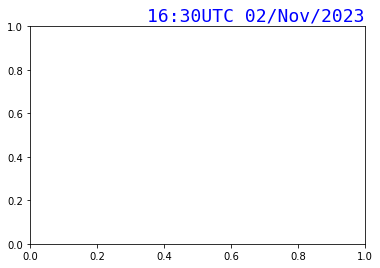

In [18]:
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC')),fontsize=18,loc='right',
#          color='blue',fontweight='normal',fontfamily='monospace')

plt.title('{}'.format(scan_start.strftime('%H:%MUTC %d/%b/%Y')),fontsize=18,loc='right',
          color='blue',fontweight='normal',fontfamily='monospace')

Text(0.0, 1.0, 'GOES-16 - FULL DISK CANAL 13\nECMWF/IFS HRES - PNMM (hPa)')

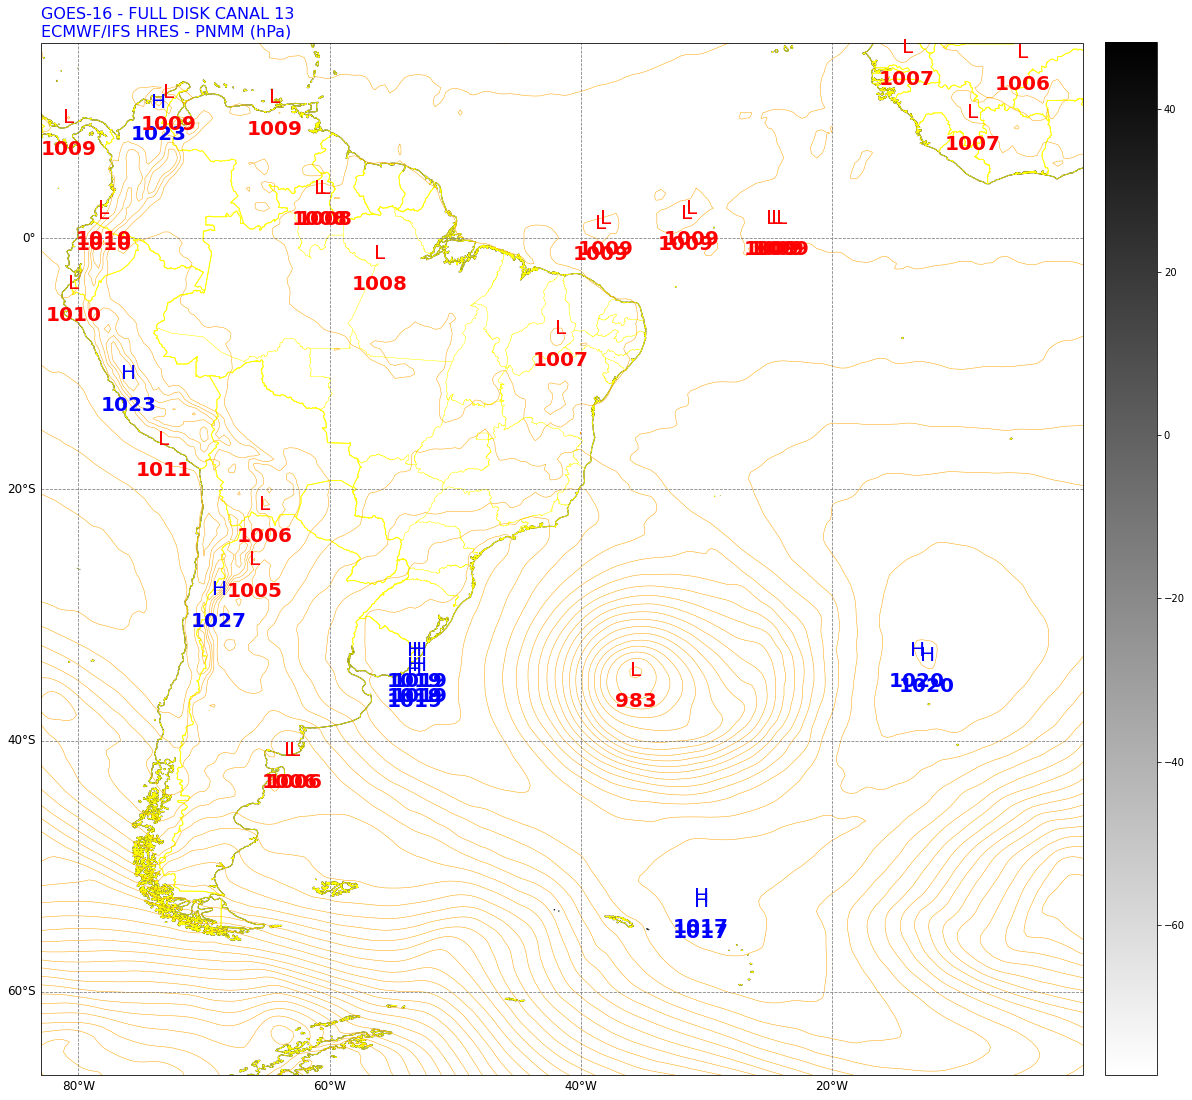

In [23]:
lon,lat=np.meshgrid(pa.longitude,pa.latitude)
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m")
#ax.set_extent([-83,-10,12,-60])
ax.set_extent([-83,0,12,-60])
#ax.set_extent([-58, -48, -22, -34])



im1=ax.contour(lon,lat,paP,np.arange(922,1082,2),
               linewidths=.5,
               colors='orange',
               transform=ccrs.PlateCarree())

plot_maxmin_points(lon,lat,pa,'max',65,symbol='H',
                   color='blue',
                   transform=ccrs.PlateCarree())
plot_maxmin_points(lon,lat,pa,'min',20,symbol='L',
                   color='red',
                      transform=ccrs.PlateCarree())

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='yellow',facecolor='none',linestyle='-',linewidth=0.8)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='yellow',facecolor='none',linestyle='-',linewidth=0.3)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}

#ax.clabel(im1, inline=1, inline_spacing=0, fontsize='10',fmt = '%1.0f', colors= 'orange')
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.0463,orientation='vertical')
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
plt.title('GOES-16 - FULL DISK CANAL 13\nECMWF/IFS HRES - PNMM (hPa)',
          fontsize=16,loc='left',color='blue')
